In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display

def read_jsonfile(json_file):
    with open(json_file) as json_file:
        json_data = json.load(json_file)
    return json_data

# 데이터 불러오기

In [2]:
path = './sample_dataset_1/'
bestshots = path + 'bestshots.json'
itemsets = path + 'itemsets.json'
category_info = 'sample_dataset_2/category_infos.json'
products_meta = 'sample_dataset_2/products_meta.json'

bestshots_json = read_jsonfile(bestshots)
itemsets_json = read_jsonfile(itemsets)
category_json = read_jsonfile(category_info)
products_json = read_jsonfile(products_meta)

category_ent1 = category_json['421B6D0E746C4E6D']
category_ent2 = category_json['B57D4F97C0E44A11']

bestshots_df = pd.read_json(bestshots)
itemsets_df = pd.read_json(itemsets)
category_en1_df = pd.DataFrame(category_ent1)
category_en2_df = pd.DataFrame(category_ent2)

In [3]:
itemsets_df.rename(columns={'enterpriseId':'enterprise_id', '_id':'id'}, inplace=True)
templates_df = pd.merge(bestshots_df, itemsets_df, on=['enterprise_id', 'projectId', 'id'])

ent2, ent1 = templates_df['enterprise_id'].unique().tolist()
ent1, ent2

('421B6D0E746C4E6D', 'B57D4F97C0E44A11')

### 스타일 별 아이템 목록 뽑기

In [4]:
def get_productId(items_list):
    new_list = []
    for item in items_list:
        new_list.append(item['productId'])
    return new_list

templates_df['items'] = templates_df['items'].apply(get_productId)

In [5]:
templates_df['top3_style'] = templates_df['style_predictions'].apply(lambda x: sorted([(name, score) for name, score in x.items()], key=lambda x: x[1], reverse=True)[:3])
templates_df['top3_style'] = templates_df['top3_style'].apply(lambda x: [name for name, score in x])

In [6]:
items_stack = pd.DataFrame(templates_df['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)

In [7]:
products_df = pd.merge(templates_df[['enterprise_id', 'top3_style', 'top_style', 'projectId', 'awesome_score']].reset_index(), items_stack.reset_index(), on='index').drop(['index'], axis=1).rename(columns = {0:'product_id'})
products_df

,enterprise_id,top3_style,top_style,projectId,awesome_score,product_id
0,B57D4F97C0E44A11,"[MODERN, MINIMAL, SCANDINAVIAN]",MODERN,X8j99sp49E05B453ACF48AD,0.996600,XXQODtk64AA2BC4BBE54FE6
1,B57D4F97C0E44A11,"[MODERN, MINIMAL, SCANDINAVIAN]",MODERN,X8j99sp49E05B453ACF48AD,0.996600,XdhSsO0816AF21BBE9E4C25
2,B57D4F97C0E44A11,"[MODERN, MINIMAL, SCANDINAVIAN]",MODERN,X8j99sp49E05B453ACF48AD,0.996600,XQKaHpw04D70BFBEB6F42EA
3,B57D4F97C0E44A11,"[MODERN, MINIMAL, SCANDINAVIAN]",MODERN,X8j99sp49E05B453ACF48AD,0.996600,3100C835A1044D48
4,B57D4F97C0E44A11,"[MODERN, MINIMAL, SCANDINAVIAN]",MODERN,X8j99sp49E05B453ACF48AD,0.996600,6E3531E25BF343BE
...,...,...,...,...,...,...
1372,B57D4F97C0E44A11,"[NATURAL, SCANDINAVIAN, MODERN]",NATURAL,X8l3PVwAE3FDA3419D145D9,0.971237,X1-HzCWC247E032E6754C6D
1373,B57D4F97C0E44A11,"[NATURAL, SCANDINAVIAN, MODERN]",NATURAL,X8l3PVwAE3FDA3419D145D9,0.971237,XkM8W9WDCCA3D3B46F3411A
1374,B57D4F97C0E44A11,"[NATURAL, SCANDINAVIAN, MODERN]",NATURAL,X8l3PVwAE3FDA3419D145D9,0.971237,6D721D1847F34015
1375,B57D4F97C0E44A11,"[NATURAL, SCANDINAVIAN, MODERN]",NATURAL,X8l3PVwAE3FDA3419D145D9,0.971237,XVUjXut5309C6E2F1704D0B


### 아이템 별 태그 정보 병합하기

In [8]:
prod_tags_df = pd.DataFrame(products_json).T.reset_index(drop=True)[['_id', 'tags', 'name', 'images']]
prod_tags_df.head()

,_id,tags,name,images
0,X5rPclT9CFB7E73DEA8495A,[],4F_TV,[https://resources.archisketch.com/product/X5r...
1,Xo7kQN3DC7A5B7C9FE746D6,"[헤이홈, hejhome, 조명, 라인등, 라인LED]",스마트 라인 LED (화이트)_on,[https://resources.archisketch.com/product/Xo7...
2,XtxfYC1EF0F9090248B4518,"[데이드리머, daydreamer, 러그, 사각러그]",브로 사계절 인테리어 러그 S,[https://resources.archisketch.com/product/Xtx...
3,XSWNaDQ8D34AB5317CA4971,"[애플, Apple, 맥북, 노트북, 사무용, 사뭉제품, 가전제품]",맥북프로 13형,[https://resources.archisketch.com/product/XSW...
4,XT21RHb69DF906D42DF4284,"[생활, 생활용품, 휴지통/분리수거함, 휴지통, 분리수거, 분리수거함, 쓰레기통, ...",원터치 와이드 화이트 휴지통 10L,[https://resources.archisketch.com/product/XT2...


In [9]:
products_df = pd.merge(products_df, prod_tags_df, left_on='product_id', right_on='_id').drop(['_id'], axis=1)
products_df = pd.merge(products_df, products_df['product_id'].value_counts().reset_index(), left_on='product_id', right_on='index').rename(columns = {'product_id_x': 'product_id','product_id_y':'use_count'}).drop(['index'], axis=1)
products_df

,enterprise_id,top3_style,top_style,projectId,awesome_score,product_id,tags,name,images,use_count
0,B57D4F97C0E44A11,"[MODERN, MINIMAL, SCANDINAVIAN]",MODERN,X8j99sp49E05B453ACF48AD,0.996600,XXQODtk64AA2BC4BBE54FE6,"[계절가전, 가습기, 가습, 화이트, 흰색, 초음파식, 초음파, EMK]",자동습도조절 스마트 초음파 가습기 EK-H3C40WH,[https://resources.archisketch.com/product/XXQ...,1
1,B57D4F97C0E44A11,"[MODERN, MINIMAL, SCANDINAVIAN]",MODERN,X8j99sp49E05B453ACF48AD,0.996600,XdhSsO0816AF21BBE9E4C25,"[소파, 쇼파, 1인용소파, 1인소파, 1인쇼파, 1인, 1인용, 1인용쇼파, 화이...",마카롱 패브릭 1인용소파 5colors (아이보리),[https://resources.archisketch.com/product/Xdh...,1
2,B57D4F97C0E44A11,"[MODERN, MINIMAL, SCANDINAVIAN]",MODERN,X8j99sp49E05B453ACF48AD,0.996600,XQKaHpw04D70BFBEB6F42EA,"[TV, 티비, 티브이, 텔레비전, 테레비, 블랙, 검정, 검은, 검은색, LED,...",43인치 스마트TV PTI43UL (스탠드),[https://resources.archisketch.com/product/XQK...,1
3,B57D4F97C0E44A11,"[MODERN, MINIMAL, SCANDINAVIAN]",MODERN,X8j99sp49E05B453ACF48AD,0.996600,3100C835A1044D48,"[러그, 한일카페트, 터치미, 극세사, 원형, 아이보리]",터치미 극세사 원형 러그 아이보리,[https://resources.archisketch.com/product/310...,1
4,B57D4F97C0E44A11,"[MODERN, MINIMAL, SCANDINAVIAN]",MODERN,X8j99sp49E05B453ACF48AD,0.996600,6E3531E25BF343BE,[],투명 식물 액자 - 몬스테라 A3사이즈,[https://resources.archisketch.com/product/6E3...,1
...,...,...,...,...,...,...,...,...,...,...
1372,B57D4F97C0E44A11,"[NATURAL, SCANDINAVIAN, MODERN]",NATURAL,X8l3PVwAE3FDA3419D145D9,0.971237,F41D77A7B85645BB,[],레트로 플라워 커튼,[https://resources.archisketch.com/product/F41...,1
1373,B57D4F97C0E44A11,"[NATURAL, SCANDINAVIAN, MODERN]",NATURAL,X8l3PVwAE3FDA3419D145D9,0.971237,XpB8ovXAD1DAF31931F4224,"[거울, 미러, 벽거울, 벽, 골드, 금색, 벽걸이형, 벽걸이, 벽걸이거울, 벽걸이...",뉴플로렌스 골드 스탠딩 거울 (골드),[https://resources.archisketch.com/product/XpB...,1
1374,B57D4F97C0E44A11,"[NATURAL, SCANDINAVIAN, MODERN]",NATURAL,X8l3PVwAE3FDA3419D145D9,0.971237,XVFHdrDE3B85E8F0BDF4E50,[],특대형 아레카야자 이태리 토분 (화이트브라운),[https://resources.archisketch.com/product/XVF...,1
1375,B57D4F97C0E44A11,"[NATURAL, SCANDINAVIAN, MODERN]",NATURAL,X8l3PVwAE3FDA3419D145D9,0.971237,6D721D1847F34015,"[반려동물, 고양이, 반려묘, 브리스캣]",O형 원목 캣타워 기본형 (그레이),[https://resources.archisketch.com/product/6D7...,1


In [10]:
# enterprise_id 별로 분류하기

products_df_4 = products_df[products_df['enterprise_id'] == ent1].reset_index(drop=True)
products_df_b = products_df[products_df['enterprise_id'] == ent2].reset_index(drop=True)
products_df_4.shape, products_df_b.shape

((188, 10), (1189, 10))

In [16]:
itemsets_4 = products_df_4.groupby('projectId')[['product_id', 'name']].agg(list).reset_index()
itemsets_b = products_df_b.groupby('projectId')[['product_id', 'name']].agg(list).reset_index()
itemsets_4.shape, itemsets_b.shape

((15, 3), (81, 3))

In [17]:
from gensim.models import Word2Vec

In [18]:
def build_model(df):
    sentence = df['name'].values.tolist()
    embedding_model = Word2Vec(sentence, vector_size=20, window = 5, 
                               min_count=1, workers=4, epochs=200, sg=1)
    return embedding_model

In [36]:
def get_rec_result(df, model, search_word_list, topn=10):
    # 유사도를 통해 추천
    result = model.wv.most_similar(positive=search_word_list, topn=topn)
    
    # 선택한 이미지들 보여주기
    for search_word in search_word_list:
        print(f'사용자가 선택한 아이템 : {search_word}')
        search_images = products_df[products_df['name'] == search_word]['images'].values.tolist()[0]
        try:
            res = requests.get(search_images[0])
            img = Image.open(BytesIO(res.content))
            display(img)
        except:
            print('이미지 없음\n')
    
    print("="*80)
    print(f"추천 아이템 Top{topn}")
    print("="*80)
    
    # 추천된 이미지들 보여주기
    for i, (name, _) in enumerate(result):
        images = products_df[products_df['name'] == name]['images'].values.tolist()[0]
        try:
            res = requests.get(images[0])
            img = Image.open(BytesIO(res.content))
            display(img)
        except:
            print('이미지 없음\n')
        print(f'{i+1}순위 추천 아이템 : {name}')
        print("-"*60)
    
    return result

In [33]:
itemsets_b

,projectId,product_id,name
0,X25sMcID0975F1628924AA1,"[XpB5qAs3DCF3BE520F9424E, XnWHmTAFECB50964AE34...","[바이엘 소프트 채널 붙박이장 크림화이트_데일리서랍형 (I형 330) (화이트), ..."
1,X6eMi9vBF9F09546EFE415A,"[9685F6318BD040E1, XxzIVRgB3C361AD014143DC, 03...","[호텔식 화이트 시폰 커튼, LED 다운라이트 3인치 블랙 COB 7W 매입등 화이..."
2,X770FPv6BDB875BF3584252,"[Xz-wAFb1866A3FD742B4A9F, Xe5Kzqn6DB1EDA89A644...","[콤펙타 조화나무 (내추럴), 대형 뱅갈 고무나무 - 원형 테라조 화분2colors..."
3,X7SS-qj98EF911061BB48A2,"[Xr78ibh6534B86500774C6F, XxzIVRgB3C361AD01414...",[QLED TV 더프레임 189cm(75) KQ75LST03AFXKR(벽걸이)(블랙...
4,X8-Asvy7EB46DF6C46E4FC5,"[XkM8XCqD087AF708AD74204, XpB8ovp03D6A032EAA94...","[SIMPLIE 협탁 BC021 (화이트), 리모네 (50x70) (화이트), CA..."
...,...,...,...
76,XmZZrnV4E91B8E058CC460D,"[Xe0hSenFC78E1F3585F401B, A6C2E049C6D34F19, Xk...","[파스텔 수국 안개 부쉬 조화_3color (블루), 코니아일랜드 장스탠드 화이트,..."
77,XrRnT_3389E4BE6D5C943F0,"[A7AE5ED7BC3B4ABD, 783FCAAD71F44652, XQGeEXg17...","[몬스테라_우드 스탠드화분(중), 32인치 게이밍모니터 QX3268 REAL165,..."
78,Xwnjamb60AEFEA4139A439E,"[A7AE5ED7BC3B4ABD, XXjvppo6E26453D34264FA8, Xj...","[몬스테라_우드 스탠드화분(중), 튤립 조화(10P) 화병 세트 옐로우, 슬림 냉장..."
79,Xx5q--z1B8186300FA64F8B,"[Xr78ib4473D0C31ABD5490F, DFA577B70C794711, B9...","[LG 퓨리케어 듀얼정수기 WU900AS(실버), 아라크네 알루미늄 25mm 블라인..."


In [34]:
emb_model_b = build_model(itemsets_b)

사용자가 선택한 아이템 : SIMPLIE 협탁 BC021 (화이트)


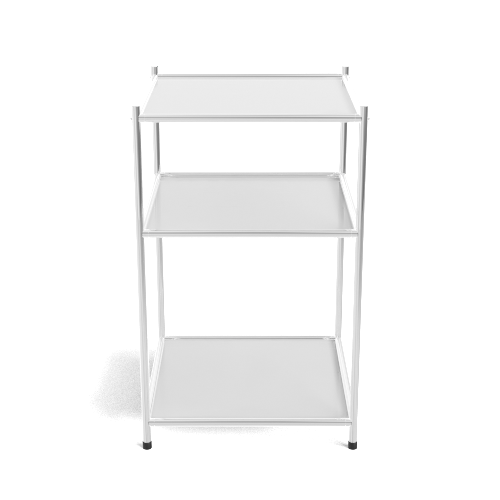

추천 아이템 Top10


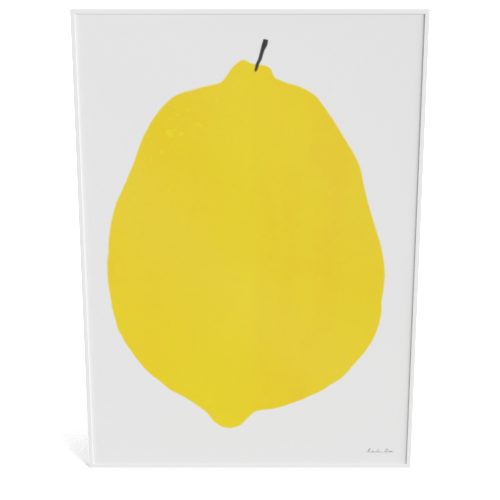

1순위 추천 아이템 : 리모네 (50x70) (화이트)
------------------------------------------------------------


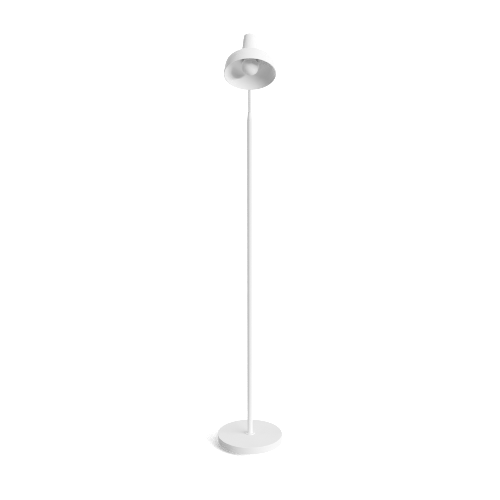

2순위 추천 아이템 : CANCUN 장스탠드 E26 KS1952F (화이트)
------------------------------------------------------------


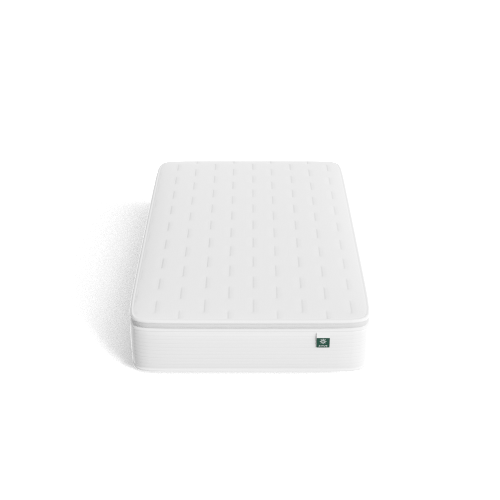

3순위 추천 아이템 : 얼티마 하이브리드 스프링 매트리스 (SS) (화이트)
------------------------------------------------------------


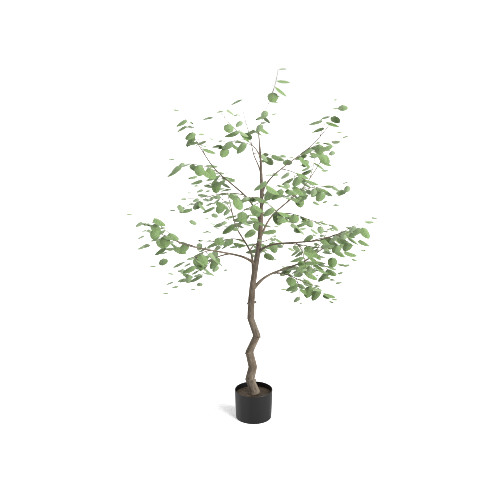

4순위 추천 아이템 : 진짜같은 조화 실버달러 유칼립투스 나무_3size 대형
------------------------------------------------------------


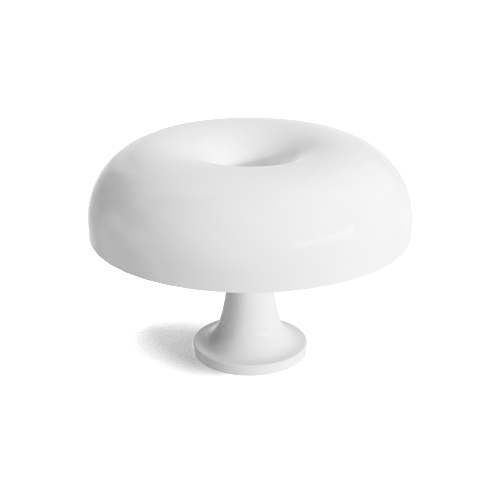

5순위 추천 아이템 : 세타 네시노 단스탠드 (화이트)
------------------------------------------------------------


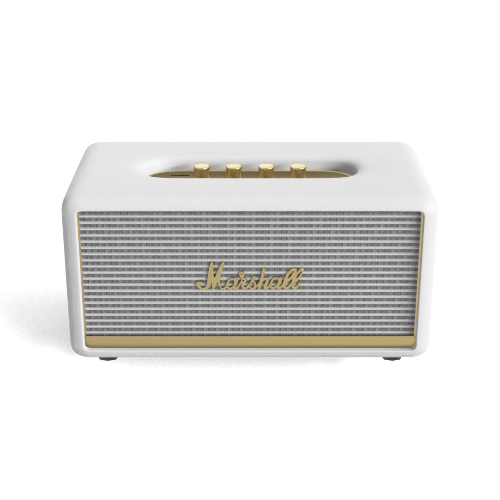

6순위 추천 아이템 : 스탠모어2 STANMORE II 블루투스 스피커 (화이트/블랙) (화이트)
------------------------------------------------------------


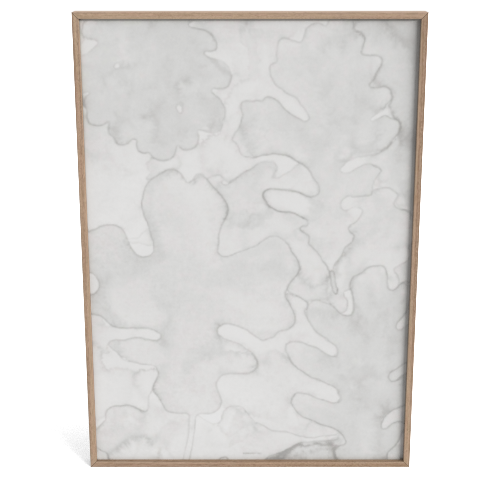

7순위 추천 아이템 : OAK LEAVES
------------------------------------------------------------


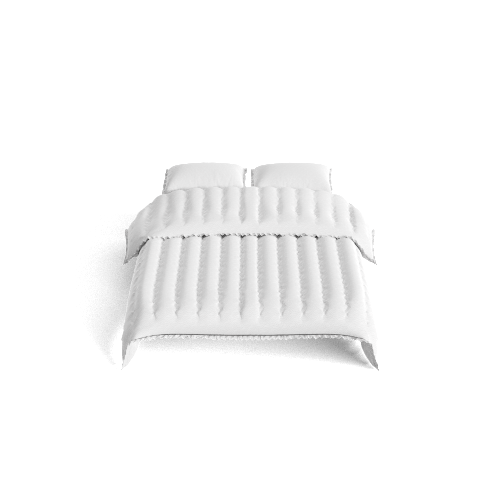

8순위 추천 아이템 : 양면 시어서커 프릴 여름차렵이불 SS 이불베개세트 2colors (화이트)
------------------------------------------------------------


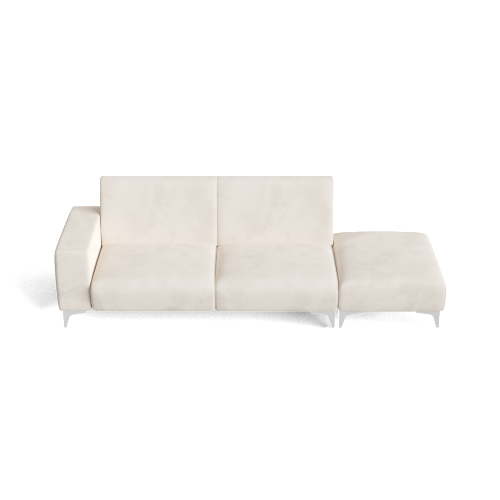

9순위 추천 아이템 : 모아나 아쿠아텍스 3인용 소파(스툴포함) (아이보리)
------------------------------------------------------------


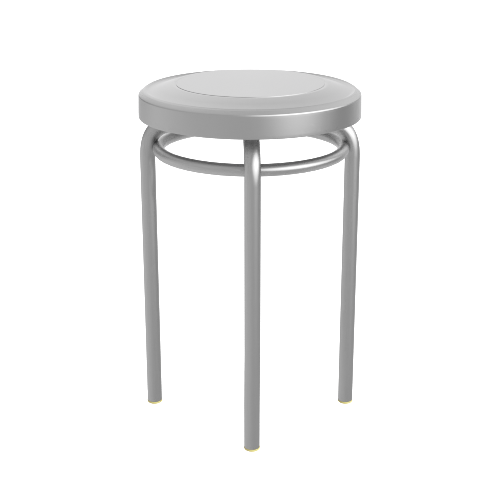

10순위 추천 아이템 : 스테인레스 라운드 스툴 (실버)
------------------------------------------------------------


[('리모네 (50x70) (화이트)', 0.99643874168396),
 ('CANCUN 장스탠드 E26 KS1952F (화이트)', 0.9942253232002258),
 ('얼티마 하이브리드 스프링 매트리스 (SS) (화이트)', 0.985895574092865),
 ('진짜같은 조화 실버달러 유칼립투스 나무_3size 대형', 0.9712061285972595),
 ('세타 네시노 단스탠드 (화이트)', 0.9576233625411987),
 ('스탠모어2 STANMORE II 블루투스 스피커 (화이트/블랙) (화이트)', 0.9544180035591125),
 ('OAK LEAVES', 0.9153429865837097),
 ('양면 시어서커 프릴 여름차렵이불 SS 이불베개세트 2colors (화이트)', 0.8688402771949768),
 ('모아나 아쿠아텍스 3인용 소파(스툴포함) (아이보리)', 0.8187602758407593),
 ('스테인레스 라운드 스툴 (실버)', 0.7687771916389465)]

In [37]:
search_word_list = ['SIMPLIE 협탁 BC021 (화이트)']

get_rec_result(itemsets_b, emb_model_b, search_word_list, topn=10)